In [1]:
# import libraries
from eodag import EODataAccessGateway
from eodag.plugins.crunch.filter_property import FilterProperty
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
from eodag import setup_logging
setup_logging(verbose=2)

import matplotlib.image as mpimg

### Load Tiles outlines

In [2]:
# load tile outlines
outline = gpd.read_file("qgis_files/sen2_tiles/tiles_outline.shp")
bretagne = gpd.read_file("qgis_files/admin/bretagne.gpkg")
query_outline = gpd.read_file("qgis_files/admin/query_shape.shp")
query_wkt = query_outline.geometry.to_wkt()[0]

# simplify geometry
#bretagne["geometry"] = bretagne["geometry"].simplify(0.0001)


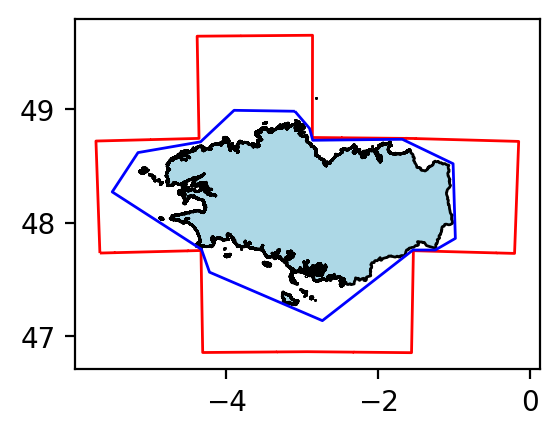

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(1, 1,figsize=(3,3), dpi=200)

bretagne.plot(ax=ax,color='lightblue', edgecolor='black')
outline.plot(ax=ax,facecolor="none",edgecolor="red",markersize=0.2)
query_outline.plot(ax=ax,facecolor="none",edgecolor="blue",markersize=0.2)
fig.show()

### Query EODAG API

In [4]:
# API core acess gateway
dag = EODataAccessGateway()

2021-11-17 22:47:12,676-15s eodag.config                     [INFO    ] Loading user configuration from: /home/simon/.config/eodag/eodag.yml
2021-11-17 22:47:12,928-15s eodag.core                       [INFO    ] Locations configuration loaded from /home/simon/.config/eodag/locations.yml


In [5]:
dag.available_providers("S2_MSI_L2A")

['astraea_eod',
 'aws_eos',
 'creodias',
 'earth_search',
 'mundi',
 'onda',
 'peps',
 'sobloo']

In [6]:
# Query for images
search_results, total_count = dag.search(
    productType='S2_MSI_L2A',
    #geom={'lonmin': 1, 'latmin': 43.5, 'lonmax': 2, 'latmax': 44}, # accepts WKT polygons, shapely.geometry, ...
    geom=query_wkt,
    start='2018-04-01',
    end='2018-09-30'
)

# filter images by Cloud Cover
filtered_products = search_results.crunch(FilterProperty({"cloudCover": 5, "operator": "lt"}))

# print info
print("Total No. of images for S2A:", len(search_results))
print("Total No. of images for S2A, max CC 5%:",len(filtered_products))

2021-11-17 22:47:13,703-15s eodag.core                       [INFO    ] Searching product type 'S2_MSI_L2A' on provider: onda
2021-11-17 22:47:13,707-15s eodag.plugins.search.qssearch    [INFO    ] Sending count request: https://catalogue.onda-dias.eu/dias-catalogue/Products/$count?productType=S2MSI2A&$search=%22footprint:%22Intersects%28POLYGON%20%28%28-3.0975%2048.9833%2C%20-2.9042%2048.8323%2C%20-2.8620%2048.7277%2C%20-1.6815%2048.7364%2C%20-1.0120%2048.5212%2C%20-0.9823%2047.8634%2C%20-1.2470%2047.7610%2C%20-1.5408%2047.7610%2C%20-2.7349%2047.1388%2C%20-4.2226%2047.5658%2C%20-4.3287%2047.7664%2C%20-5.5052%2048.2729%2C%20-5.1651%2048.6192%2C%20-4.3400%2048.7141%2C%20-3.8989%2048.9915%2C%20-3.0975%2048.9833%29%29%29%22%20AND%20productType:S2MSI2A%20AND%20beginPosition:[2018-04-01T00:00:00.000Z%20TO%20%2A]%20AND%20endPosition:[%2A%20TO%202018-09-30T00:00:00.000Z]%22
2021-11-17 22:47:17,924-15s eodag.plugins.search.qssearch    [INFO    ] Sending search request: https://catalogue.onda-d

Total No. of images for S2A: 20
Total No. of images for S2A, max CC 5%: 3


### Download QuickLooks

In [7]:
"""
dag.serialize(filtered_products,filename="tmp/saved_search.json")
"""

'\ndag.serialize(filtered_products,filename="tmp/saved_search.json")\n'

In [8]:
"""
deserialized_and_registered = dag.deserialize_and_register("tmp/saved_search.json")
quicklook_path = deserialized_and_registered[0].get_quicklook(base_dir="")
"""

'\ndeserialized_and_registered = dag.deserialize_and_register("tmp/saved_search.json")\nquicklook_path = deserialized_and_registered[0].get_quicklook(base_dir="")\n'

In [9]:
"""
search_results = dag.deserialize_and_register(filtered_products)

fig = plt.figure(figsize=(10, 8))
for i, product in enumerate(filtered_products, start=1):
    print(product)

    # This line takes care of downloading the quicklook
    quicklook_path = product.get_quicklook()

    # Plot the quicklook
    img = mpimg.imread(quicklook_path)
    ax = fig.add_subplot(3, 4, i)
    ax.set_title(i - 1)
    plt.imshow(img)
plt.tight_layout()
"""

'\nsearch_results = dag.deserialize_and_register(filtered_products)\n\nfig = plt.figure(figsize=(10, 8))\nfor i, product in enumerate(filtered_products, start=1):\n    print(product)\n\n    # This line takes care of downloading the quicklook\n    quicklook_path = product.get_quicklook()\n\n    # Plot the quicklook\n    img = mpimg.imread(quicklook_path)\n    ax = fig.add_subplot(3, 4, i)\n    ax.set_title(i - 1)\n    plt.imshow(img)\nplt.tight_layout()\n'

### Download Imagery

In [ ]:
# check which ones are online
[p.properties["storageStatus"] for p in filtered_products]

In [ ]:
# filter for online products
online_search_results = search_results.crunch(FilterProperty(dict(storageStatus="ONLINE")))
[p.properties["storageStatus"] for p in online_search_results]

In [ ]:
# download products
paths = dag.download_all(filtered_products)